<a href="https://colab.research.google.com/github/mayraberrones94/Ciencia_de_Datos/blob/master/Sentiment_analysis_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup kaggle API

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


## Import Important Packages

In [ ]:

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.utils import shuffle
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
DATASET_ENCODING = "ISO-8859-1"


In [ ]:
tf.__version__

'2.3.0'

## Download and process Twitter Sentiment dataset

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
df = pd.read_csv("/content/sentiment140.zip",encoding=DATASET_ENCODING)
df= df.iloc[:,[0,-1]]
df.columns = ['sentiment','tweet']
df = pd.concat([df.query("sentiment==0").sample(20000),df.query("sentiment==4").sample(20000)])
df.sentiment = df.sentiment.map({0:0,4:1})
df =  shuffle(df).reset_index(drop=True)

df,df_test = train_test_split(df,test_size=0.2)

In [ ]:
df.head(5)

,sentiment,tweet
29039,1,"@tommcfly *------* u wrote a song in brazil, w..."
6839,0,@amazingphoebe it is until you actually start ...
36081,1,@SeasonedWTime better have a strong cup of cof...
15445,0,@MNMorgan I want to go! But I have to work all...
22537,1,had a fantastic weekend


## Load Universal Sentence Encoder from TFhub

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [ ]:
embed(['hi samuels, this is our project']).numpy().shape

(1, 512)

In [ ]:
def vectorize(df):
    embeded_tweets = embed(df['tweet'].values.tolist()).numpy()
    targets = df.sentiment.values
    return embeded_tweets,targets

embeded_tweets,targets = vectorize(df)


## Model 

In [ ]:
model = Sequential()
model.add(Input(shape=(512,),dtype='float32'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


## Train and evaluate

In [ ]:
num_epochs = 10
batch_size = 32   ## 2^x

history = model.fit(embeded_tweets, 
                    targets, 
                    epochs=num_epochs, 
                    validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size)

Epoch 1/10
900/900 [==============================] - 1s 1ms/step - loss: 0.4821 - acc: 0.7686 - val_loss: 0.4384 - val_acc: 0.7891
Epoch 2/10
900/900 [==============================] - 1s 1ms/step - loss: 0.4450 - acc: 0.7911 - val_loss: 0.4305 - val_acc: 0.7962
Epoch 3/10
900/900 [==============================] - 1s 1ms/step - loss: 0.4168 - acc: 0.8107 - val_loss: 0.4326 - val_acc: 0.7928
Epoch 4/10
900/900 [==============================] - 1s 1ms/step - loss: 0.3798 - acc: 0.8312 - val_loss: 0.4525 - val_acc: 0.7837
Epoch 5/10
900/900 [==============================] - 1s 1ms/step - loss: 0.3381 - acc: 0.8537 - val_loss: 0.4688 - val_acc: 0.7803
Epoch 6/10
900/900 [==============================] - 1s 1ms/step - loss: 0.2948 - acc: 0.8771 - val_loss: 0.5120 - val_acc: 0.7725
Epoch 7/10
900/900 [==============================] - 1s 1ms/step - loss: 0.2500 - acc: 0.8988 - val_loss: 0.6094 - val_acc: 0.7638
Epoch 8/10
900/900 [==============================] - 1s 1ms/step - loss: 0.

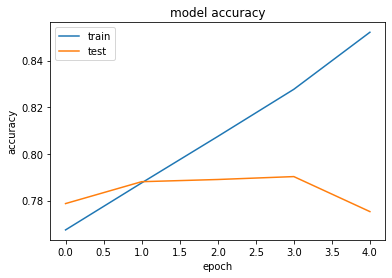

In [ ]:


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


## Compare results


In [ ]:
from sklearn.metrics import accuracy_score

## Custom Model 

In [ ]:
embed_test,targets = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
accuracy_score(predictions,targets)*100

49.925000000000004

## Textblob

In [ ]:
!pip install -q textblob 

In [ ]:
from textblob import TextBlob

def text_sentiment(text):
    testimonial = TextBlob(text)
    return int(testimonial.sentiment.polarity>0.5)

predictions = df_test.tweet.map(lambda x :  text_sentiment(x))
accuracy_score(predictions,targets)

0.558625

In [ ]:
analyzer.polarity_scores("The food as great!")

{'compound': 0.6588, 'neg': 0.0, 'neu': 0.406, 'pos': 0.594}

## Vader

In [ ]:
pip install -q vaderSentiment

     |████████████████████████████████| 133kB 9.5MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def text_sentiment_vader(text):
 vs = analyzer.polarity_scores(text)
 return int(vs.get("compound")>0)
 
 predictions = df_test.tweet.map(lambda x : text_sentiment_vader(x))


In [ ]:
 accuracy_score(predictions.values,targets)

0.558625

## Flair

In [ ]:
!pip install -q flair 

     |████████████████████████████████| 337kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.0MB/s 
     |████████████████████████████████| 19.7MB 1.2MB/s 
     |████████████████████████████████| 276kB 48.2MB/s 
     |████████████████████████████████| 1.1MB 47.7MB/s 
     |████████████████████████████████| 798kB 41.8MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 983kB 43.8MB/s 
     |████████████████████████████████| 3.0MB 46.2MB/s 
     |████████████████████████████████| 890kB 39.0MB/s 
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=cf47a3857790931cc2e5d624ea7bf233b3524bcabb924d133dbf76a2403dc921
  Stored in directory: /root/.cache/pip/wheels/b4/39/f6/9ca1c5cabde964d728023b5751c3a206a5c8cc40252321fb6b
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=145c5230dc506b01f398b0d14568379c037aa1e5d9e8cd27300d09d554c1afa5
  Stored in directory: /r

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

def text_sentiment_flair(text):
  sentence = Sentence(text)
  classifier.predict(sentence)
  return np.round(sentence.labels[0].score)

predictions = df_test.tweet.map(lambda x : text_sentiment_flair(x))


2020-10-04 03:44:40,992 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


0.503625

In [ ]:
accuracy_score(predictions.values,targets)


0.503625

In [ ]:
sentence=Sentence("The food was great!")
classifier.predict(sentence)
sentence.labels

[POSITIVE (0.9961)]